In [22]:
SEED = 2023
TDDPM_DIR = "/home/liu00980/Documents/syn/tab-ddpm"
cuda_device = "cuda:0"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dython.nominal import associations

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from scipy.interpolate import splrep, BSpline
from pytorch_lightning import seed_everything

import os
import json
import pickle
from copy import deepcopy
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import quantile_transform, OneHotEncoder, QuantileTransformer


import sys

sys.path.insert(0, os.path.join(TDDPM_DIR, "utils"))

from utils_syn import (
    concat_data,
    catboost_pred_model,
    test_acc,
)

from utils_num import (
    calculate_fid, 
    wasserstein_1_distance, 
    wasserstein_2_distance,
)

from utils_viz import (
    compare_distributions_grid,
    heatmap_correlation,
)

plt.style.use("bmh")

In [10]:
class MySpline:
    def __init__(self, x, y, n_interior_knots=5, k=3):
        """
        1-d B-spline for spline smoothing.
        x: numpy array of shape (n, 1)
        y; numpy array of shape (n, )
        n_interior_knots: number of interior knots (-> quantile of x as interior knots of the spline)
        k: degree of the spline fit (e.g. 3 for cubic spline)
        """

        # specify spline knots based on quantiles of x
        qs = np.linspace(0, 1, n_interior_knots + 2)[1:-1]
        knots = np.quantile(x, qs)
        t, c, k = splrep(x, y, t=knots, k=k)

        dmatrix_raw = BSpline.design_matrix(x.reshape(-1), t, k).toarray()
        xtx = np.linalg.pinv(dmatrix_raw.T @ dmatrix_raw)
        beta_hat = xtx @ dmatrix_raw.T @ y

        sigma_hat = np.sqrt(
            np.sum((y - dmatrix_raw @ beta_hat) ** 2) / (len(y) - len(beta_hat))
        )

        self.tck = (t, c, k)
        self.dmatrix_raw = dmatrix_raw
        self.xtx = xtx
        self.beta_hat = beta_hat
        self.sigma_hat = sigma_hat

    def pred(self, x):
        """Predict y given x using beta_hat (estimated from spline) and get SE for the prediction"""
        if len(x.shape) == 2 and x.shape[1] == 1:
            x = x.reshape(-1)
        dmatrix = BSpline.design_matrix(x, self.tck[0], self.tck[2]).toarray()

        y_pred = dmatrix @ self.beta_hat
        y_pred_se = self.sigma_hat * np.diag(dmatrix @ self.xtx @ dmatrix.T)

        return y_pred, y_pred_se



class Adult(Dataset):
    def __init__(self, X: torch.Tensor, y: torch.Tensor):
        """
        X should be a torch tensor of shape (n, d), where:
        - numerical features are already quantile transformed
        - categorical features are already one-hot encoded
        """
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [11]:

def gender_transform_x_y(df: pd.DataFrame, transform: ColumnTransformer):
    """
    Transform the data using the pipeline and return X and y
    - X will be a torch tensor of shape (n, d)
    - y will be a torch tensor of shape (n, )
    """
    X = torch.tensor(transform.transform(df).toarray(), dtype=torch.float32)
    y = torch.tensor(df[gender_names_dict["y_feature"]].to_numpy(dtype=int))
    return X, y


def mlp_val_epoch(model, val_dl, **kwargs):
    """
    Validate at the end of each epoch
    - model, val_dl: the model and the validation dataloader
    """
    model.eval()
    
    val_loss = []
    val_correct, val_total = 0, 0
    for X, y in val_dl:
        X, y = X.to(kwargs["cuda_device"]), y.to(kwargs["cuda_device"])
        y_pred = model(X)
        loss = kwargs["loss_fn"](y_pred, y)

        val_loss.append(loss.item())
        val_total += y.shape[0]
        val_correct += (y_pred.argmax(dim=1) == y).sum().item()

    return np.mean(val_loss), val_correct / val_total


def mlp_train_epoch(model, train_dl, optimizer, **kwargs):
    """
    Train the MLP model for one_epoch
    - model, train_dl: the model and the training dataloader
    """
    model.train()
    
    train_loss = []
    train_correct, train_total = 0, 0
    for X, y in train_dl:
        X, y = X.to(kwargs["cuda_device"]), y.to(kwargs["cuda_device"])
        y_pred = model(X)
        loss = kwargs["loss_fn"](y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
        train_total += y.shape[0]
        train_correct += (y_pred.argmax(dim=1) == y).sum().item()
    
    return np.mean(train_loss), train_correct / train_total


## Generation quality of fine-tuned model on Adult-Female data

In [2]:

df_dict = pickle.load(open("temp_df_dict.pkl", "rb"))

male_df = df_dict["male_df"]
female_df_twin1_test = df_dict["female_df_twin1_test"]
fake_female_df_pt = df_dict["fake_female_df_pt"]
fake_female_df = df_dict["fake_female_df"]
fake_male_df = df_dict["fake_male_df"]

gender_names_dict = df_dict["gender_names_dict"]


### Marginal distribution

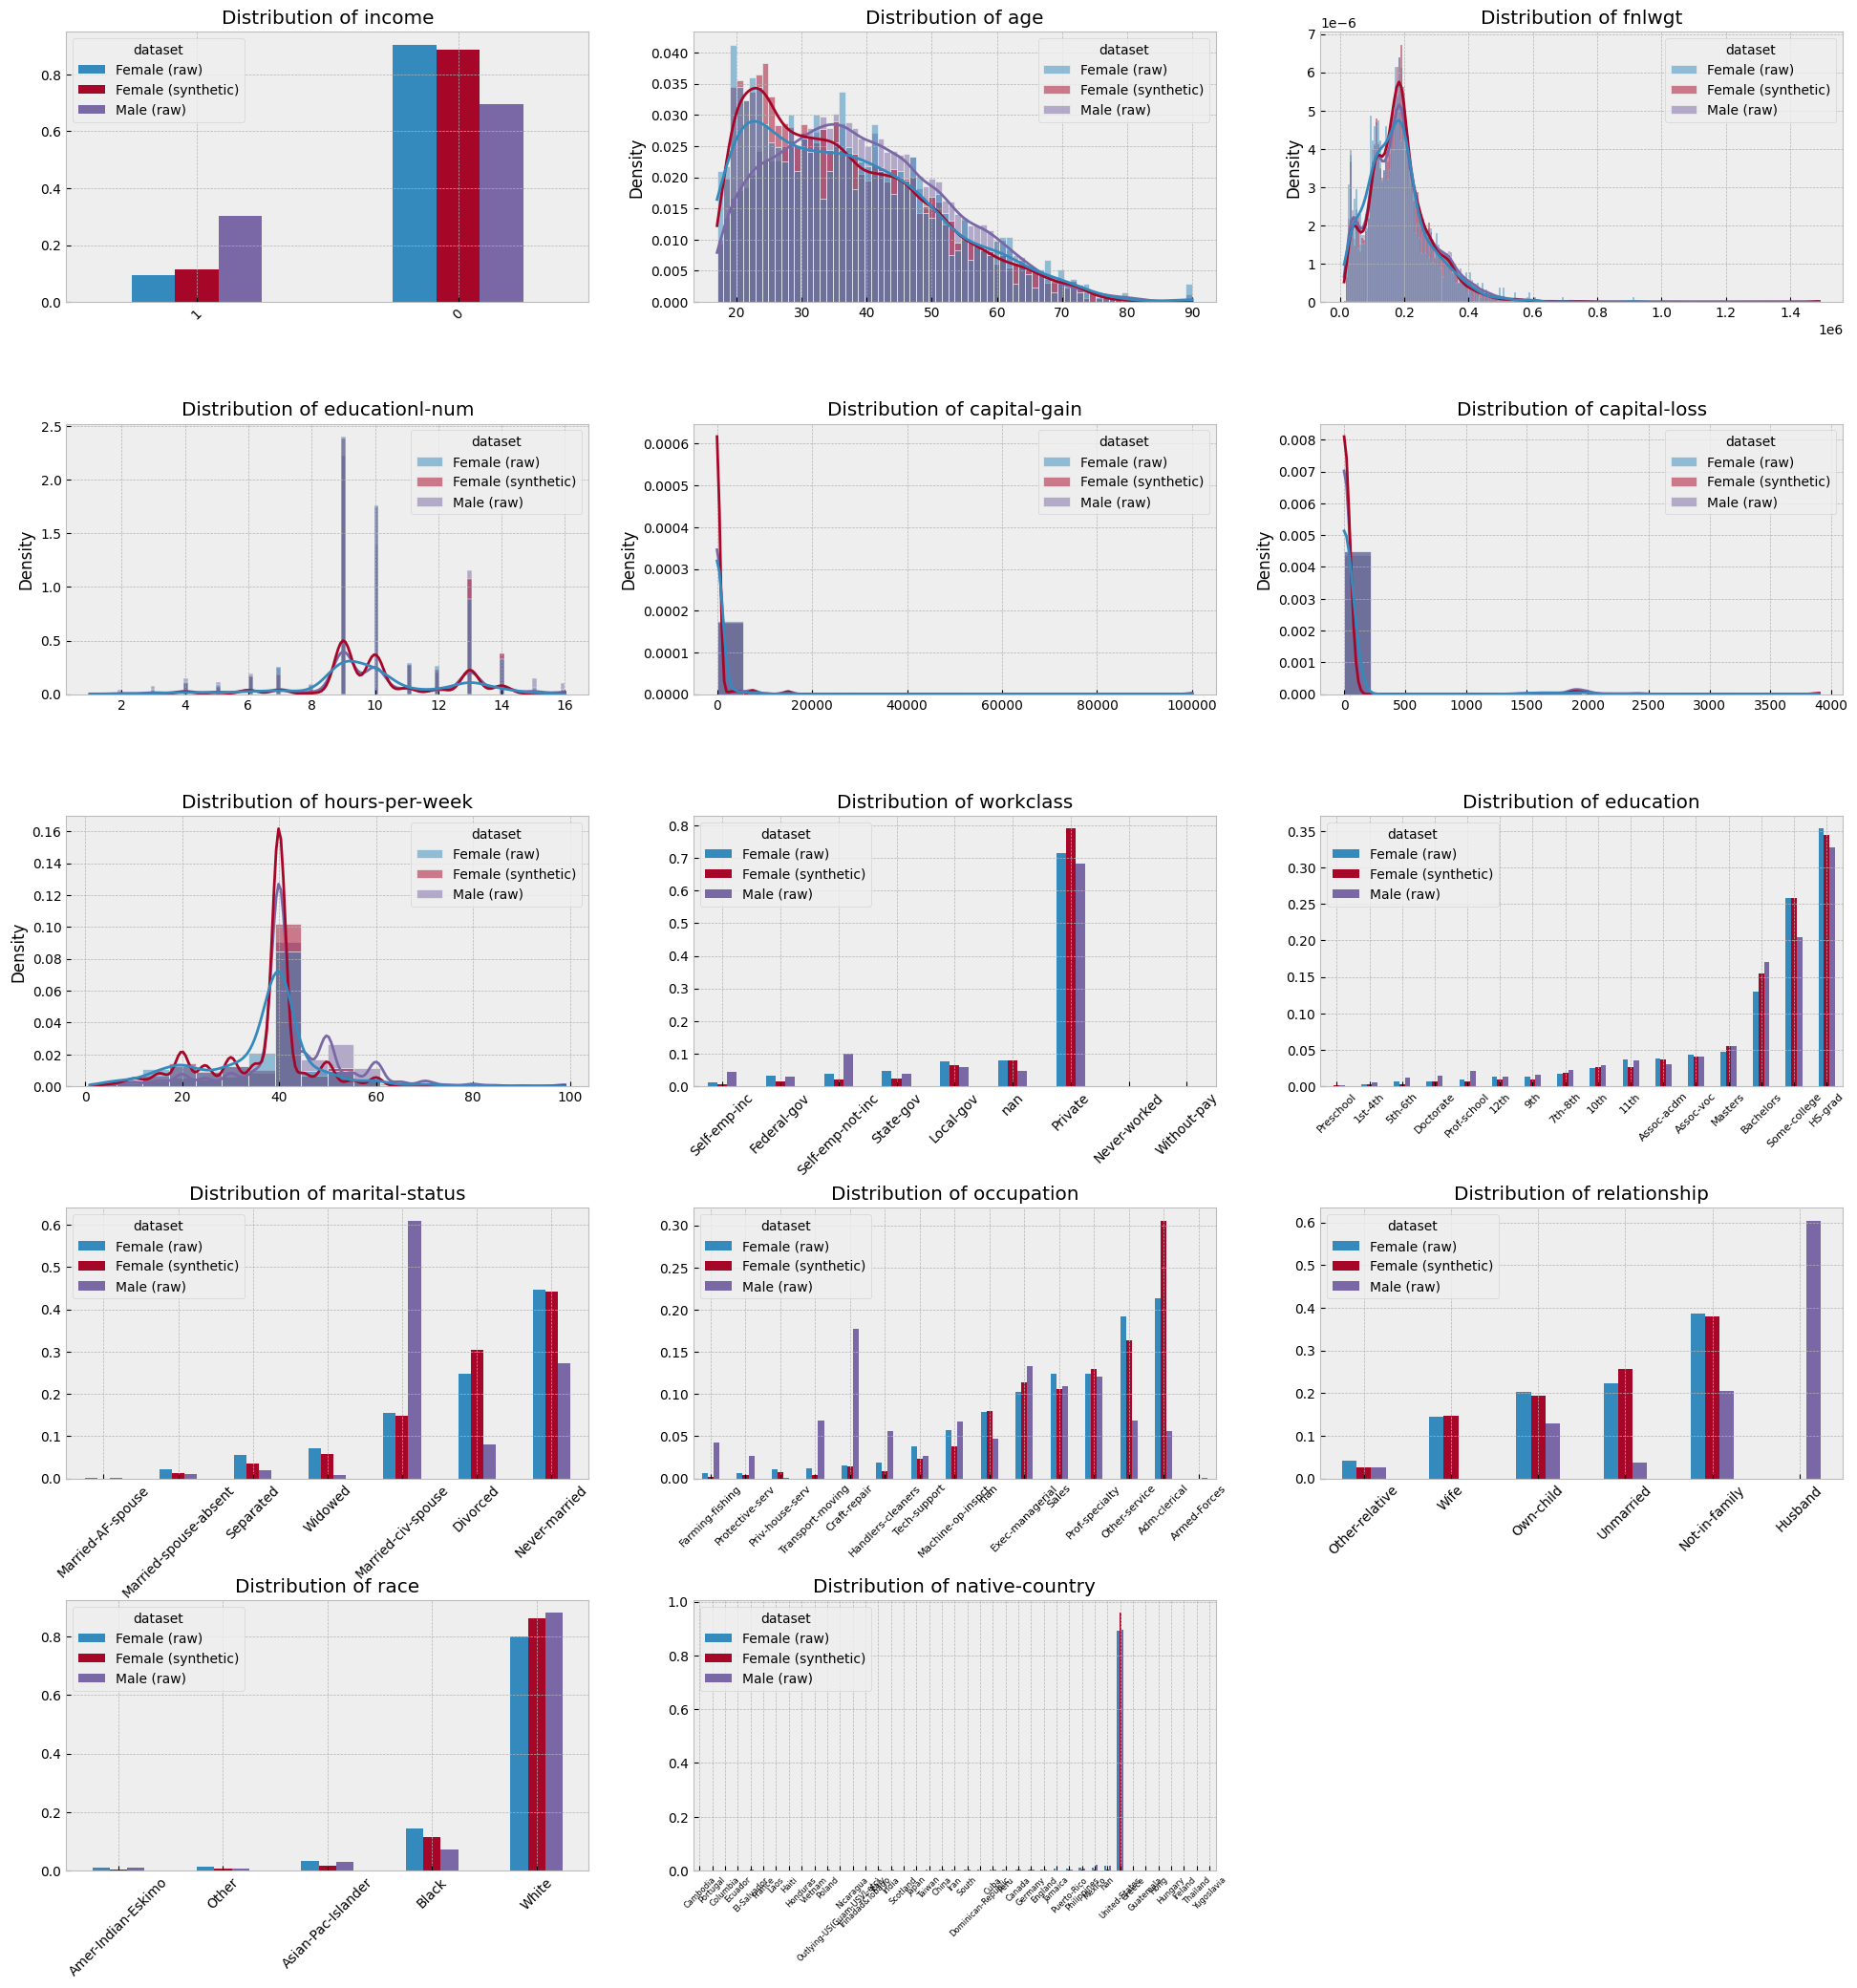

In [3]:
df_list = [female_df_twin1_test, fake_female_df, male_df]
df_names_list = ["Female (raw)", "Female (synthetic)", "Male (raw)"]
compare_distributions_grid(df_list, df_names_list, 5, 3)

### Pairwise correlations

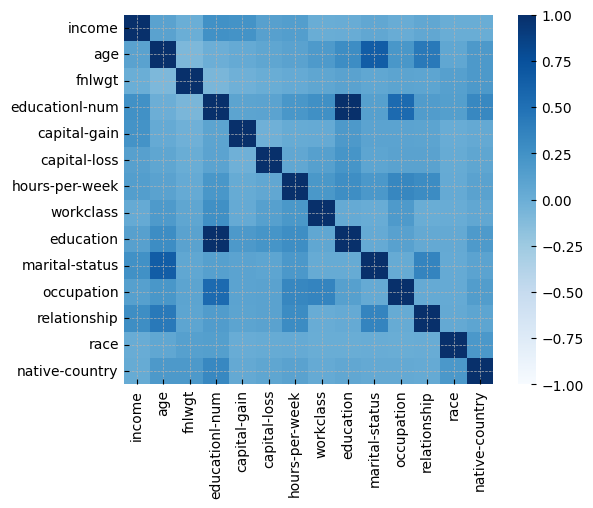

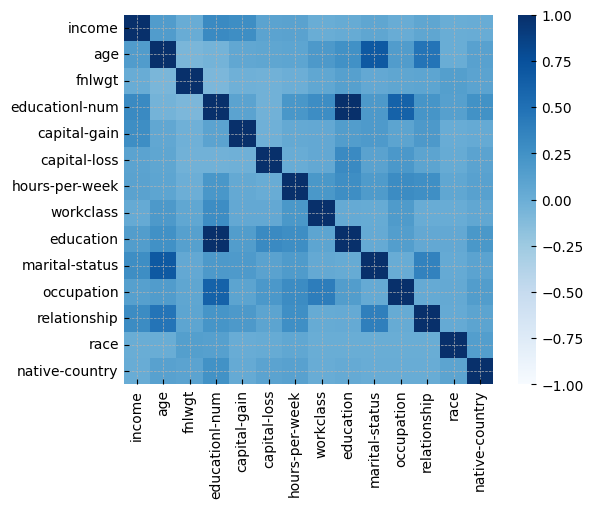

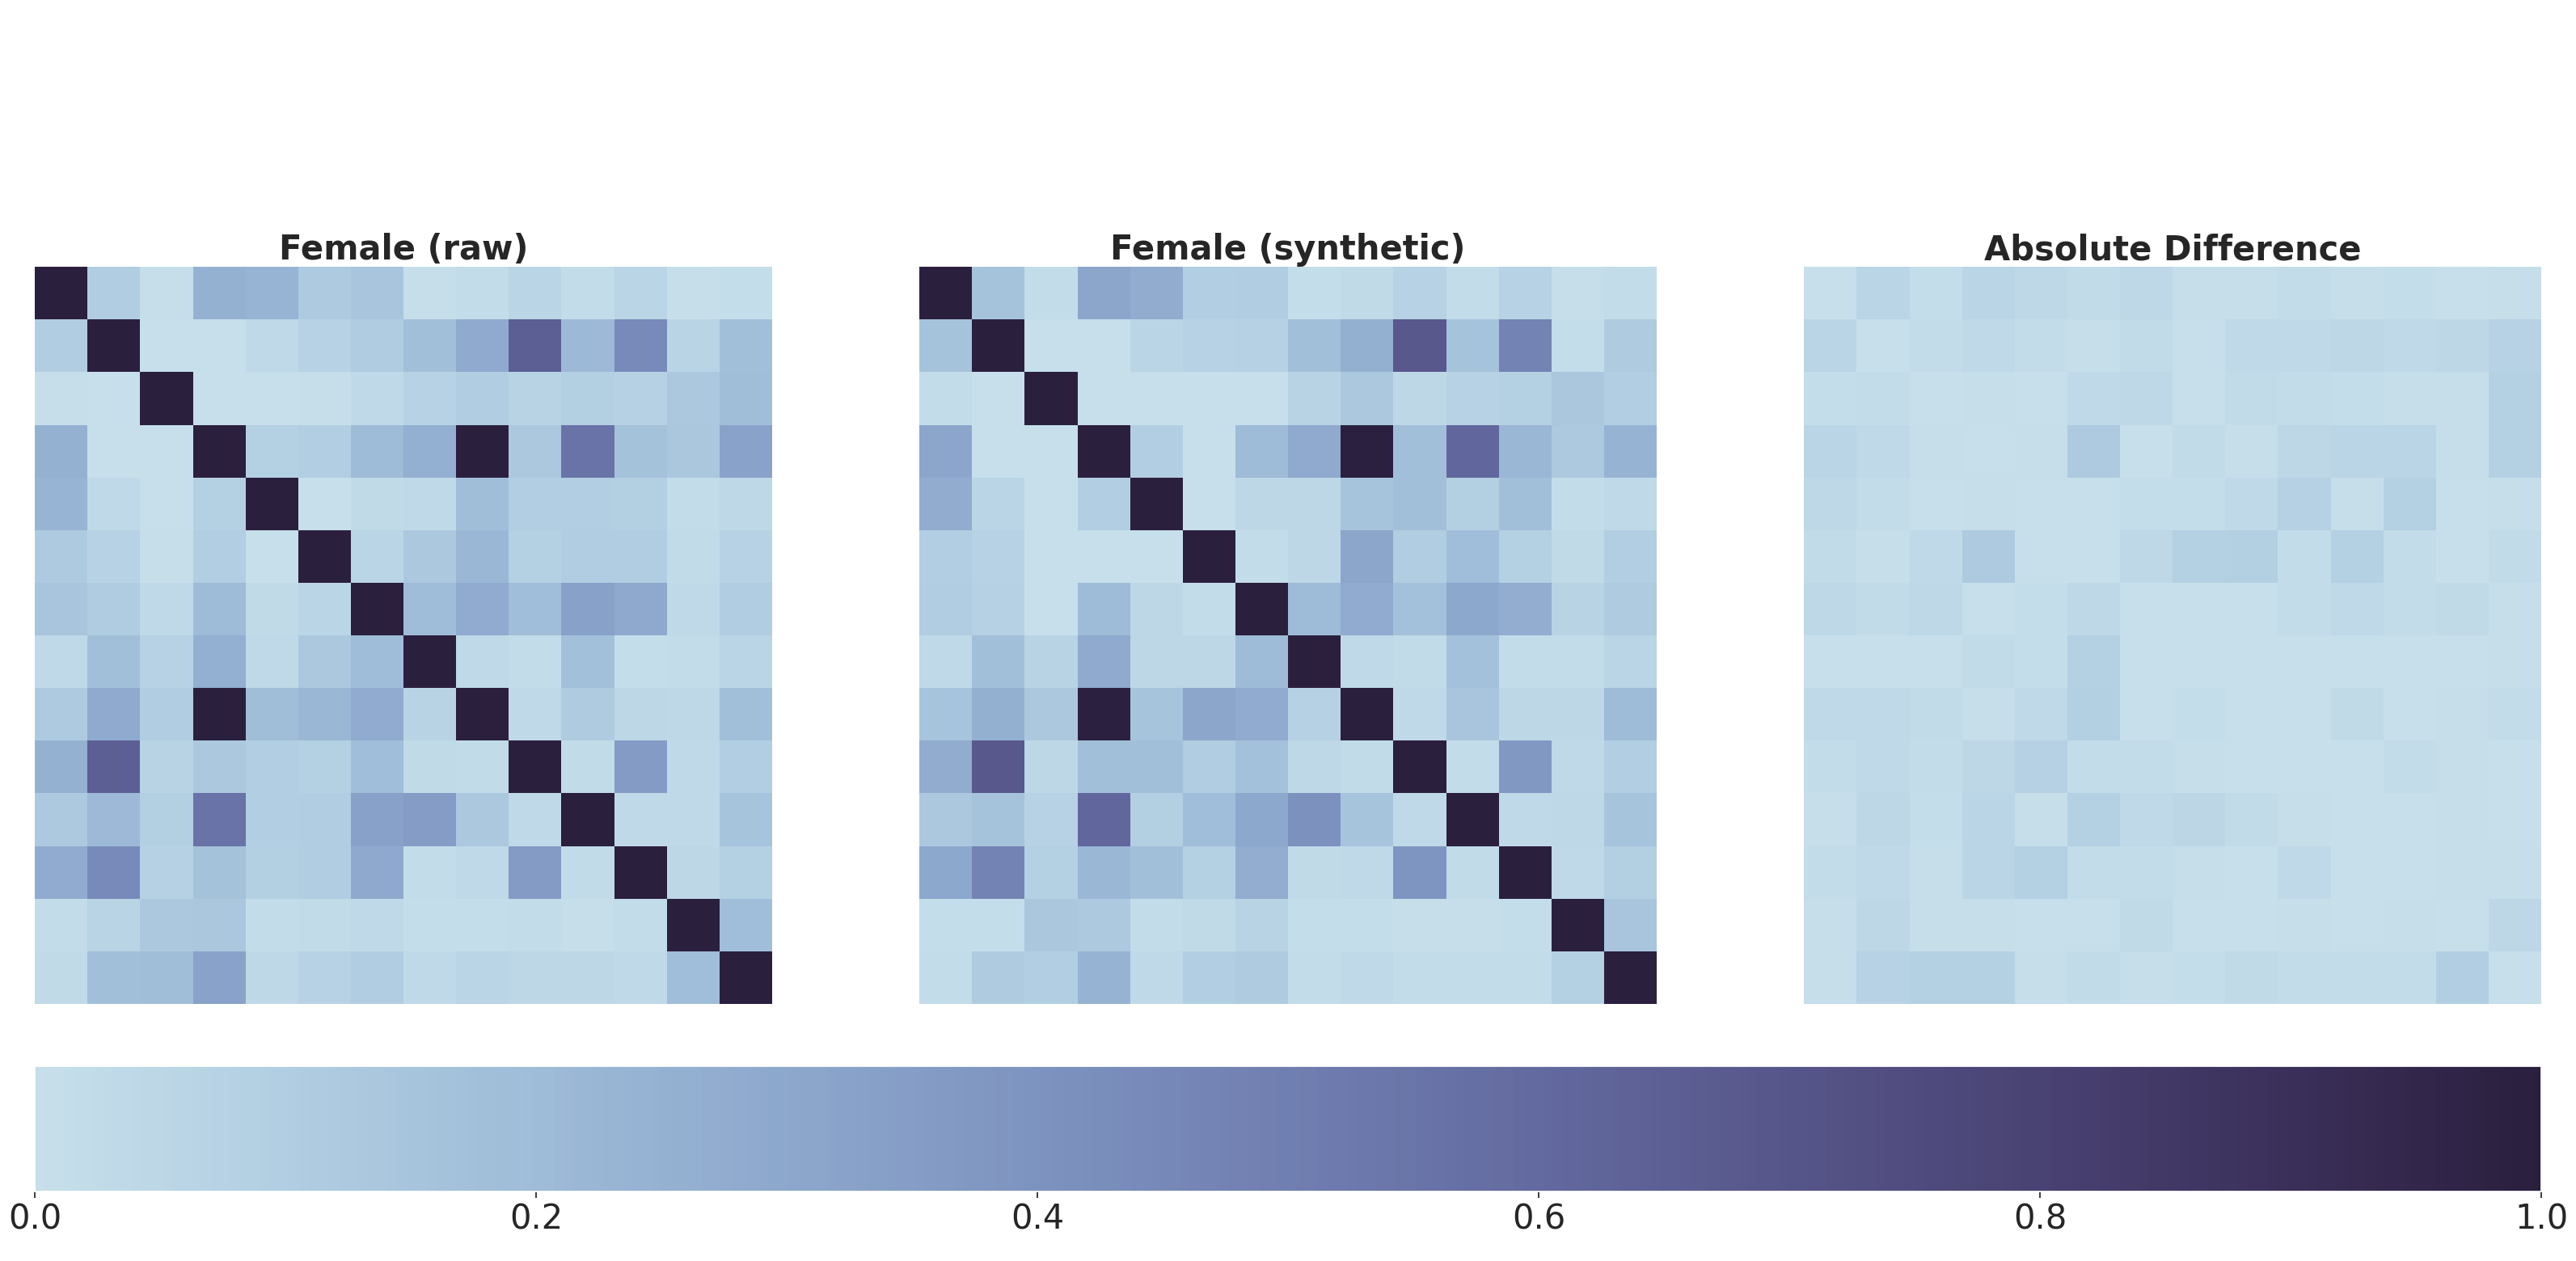

In [4]:
heatmap_correlation(female_df_twin1_test, fake_female_df, "Female (raw)", "Female (synthetic)")

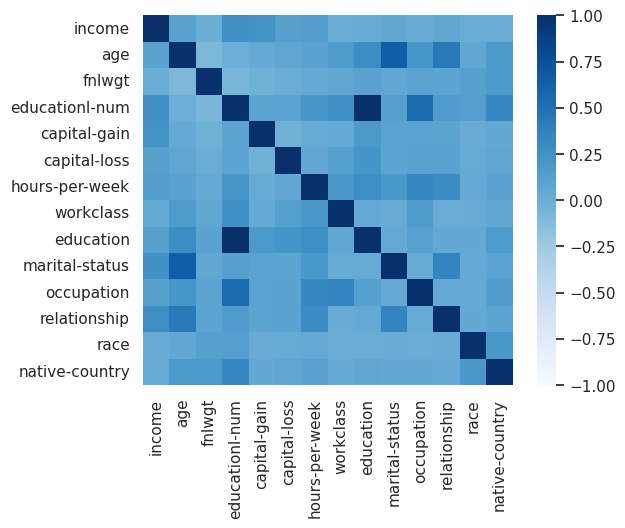

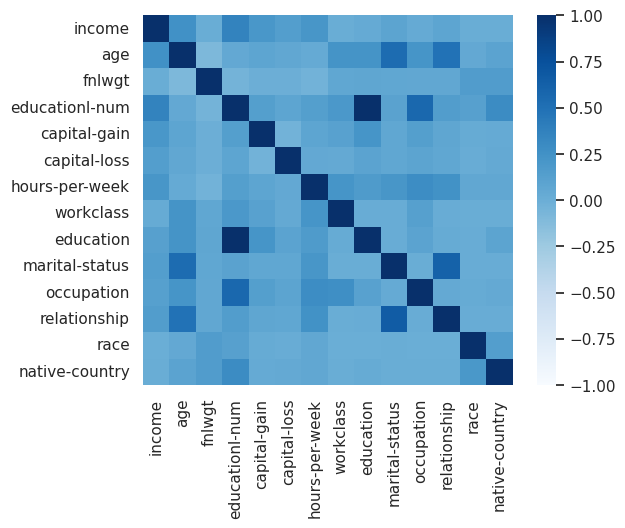

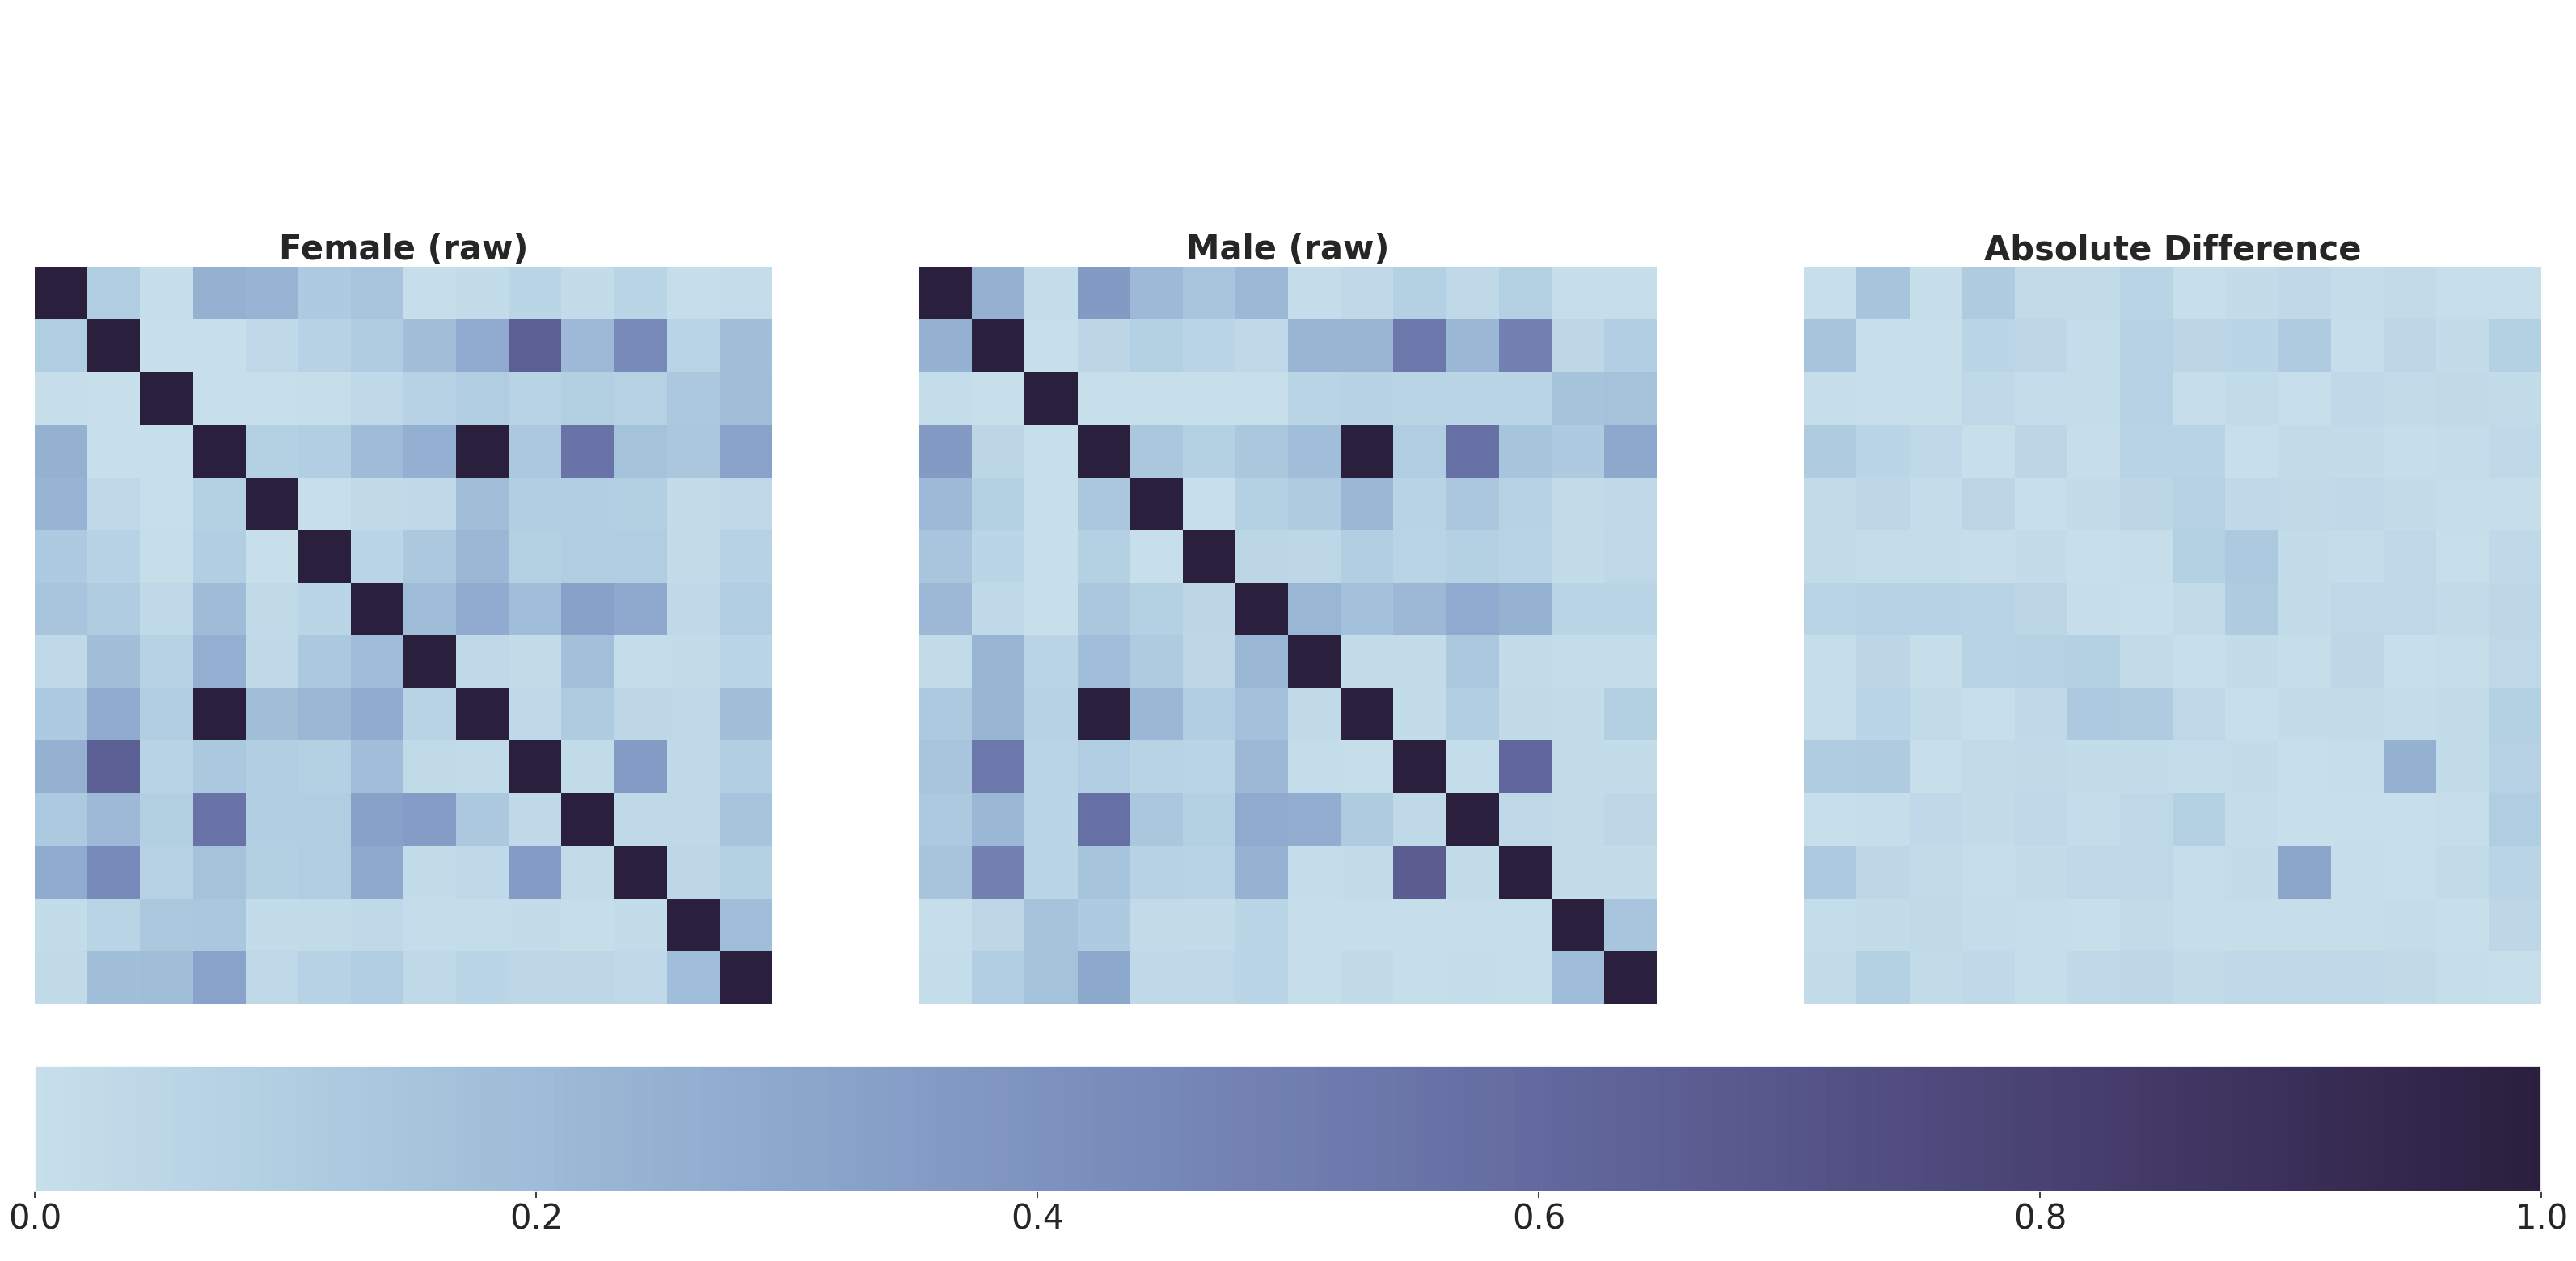

In [5]:
heatmap_correlation(female_df_twin1_test, male_df, "Female (raw)", "Male (raw)")

### Distribution metrics

In [6]:
# process the columns

fake_female_df_pt["source"] = "female_pretrained"
fake_female_df["source"] = "female_finetuned"
female_df_twin1_test["source"] = "female_raw"

temp_male_df = male_df.copy()
temp_male_df["source"] = "male_raw"
fake_male_df["source"] = "male_pretrained"


# quantile transformation for numerical features
for temp_df in [
    fake_female_df_pt,
    fake_female_df,
    female_df_twin1_test,
    temp_male_df,
    fake_male_df,
]:
    temp_df[gender_names_dict["num_features_list"]] = quantile_transform(
        temp_df[gender_names_dict["num_features_list"]],
        random_state=0,
        output_distribution="uniform",
    )

# one-hot encoding on categorical features (need to combine them all to get all levels presented in categorical variables)

temp_overall_df = pd.concat(
    [
        fake_female_df_pt,
        fake_female_df,
        female_df_twin1_test,
        temp_male_df,
        fake_male_df,
    ],
    axis=0,
    ignore_index=True,
)

temp_overall_df = pd.get_dummies(
    temp_overall_df,
    columns=[gender_names_dict["y_feature"]] + gender_names_dict["cat_features_list"],
)


pt_female_processed = temp_overall_df[temp_overall_df["source"] == "female_pretrained"].drop(columns=["source"])
ft_female_processed = temp_overall_df[temp_overall_df["source"] == "female_finetuned"].drop(columns=["source"])
raw_female_processed = temp_overall_df[temp_overall_df["source"] == "female_raw"].drop(columns=["source"])
raw_male_processed = temp_overall_df[temp_overall_df["source"] == "male_raw"].drop(columns=["source"])
pt_male_processed = temp_overall_df[temp_overall_df["source"] == "male_pretrained"].drop(columns=["source"])


print(pt_female_processed.shape)
print(ft_female_processed.shape)
print(raw_female_processed.shape)
print(raw_male_processed.shape)
print(pt_male_processed.shape)

(32650, 107)
(32650, 107)
(1350, 107)
(32650, 107)
(32650, 107)


In [7]:
comparison_df_list = [raw_male_processed, pt_male_processed, pt_female_processed, ft_female_processed]
comparison_names_list = ["Female (raw) V.S. Male (raw)", "Female (raw) V.S. Male (PT)", "Female (raw) V.S. Female (PT)", "Female (raw) V.S. Female (FT)"]

distance_list = []
for df_processed in comparison_df_list:
    fid_score = calculate_fid(df_processed, raw_female_processed)
    w1_distance = wasserstein_1_distance(df_processed, raw_female_processed)
    w2_distance = wasserstein_2_distance(df_processed, raw_female_processed)
    
    distance_list.append([fid_score, w1_distance, w2_distance])

pd.DataFrame(
    distance_list,
    index=comparison_names_list,
    columns=["FID (Gaussian)", "Wasserstein-1", "Wasserstein-2"],
)

,FID (Gaussian),Wasserstein-1,Wasserstein-2
Female (raw) V.S. Male (raw),1.971294,1.968028,2.124779
Female (raw) V.S. Male (PT),2.034690,1.959714,2.124149
Female (raw) V.S. Female (PT),0.465233,1.293403,1.537583
Female (raw) V.S. Female (FT),0.247993,1.169176,1.395702


## Syn-Boost evaluation

In [12]:
n = 1350
rho_max, num_rhos = 30, 30
rho_list = np.linspace(0, rho_max, num_rhos + 1)[1:]

In [13]:
# Get the true female data (twin_1 or twin_2 test) as the raw dataset
df_female_raw = concat_data(
    f"{TDDPM_DIR}/data/adult_female_3000_twin_1",
    split="train",
    **gender_names_dict,
)

# Get the test female data (twin_2 or twin_1 test) as the validation set
df_female_test = concat_data(
    f"{TDDPM_DIR}/data/adult_female_3000_twin_1",
    split="test",
    **gender_names_dict,
)

### Train using raw sample (Female twin 2)

In [15]:
cat_model = catboost_pred_model(
    df_female_raw,
    df_female_test,
    **gender_names_dict,
    iterations=1000,
    verbose=False
)

score = test_acc(cat_model, df_female_test, **gender_names_dict)
print("Test accuracy:", score)

no null features, using all specified features for training
Test accuracy: 0.9303703703703704


### Transfer learning with FNN

Pre-train FNN with Male data while fine-tuning it on Female data 

In [17]:
df_male = concat_data(
    f"{TDDPM_DIR}/data/adult_male",
    split="train",
    **gender_names_dict,
)

df_male_train, df_male_val = train_test_split(df_male, test_size=0.05, random_state=SEED)

In [18]:
# Male: pre-process the data and keep the pipeline
transform_male_train = ColumnTransformer(
    [
        ("num", QuantileTransformer(random_state=SEED), gender_names_dict["num_features_list"]),
        ("cat", OneHotEncoder(dtype="int"), gender_names_dict["cat_features_list"]),
    ],
)
transform_male_train.fit(df_male_train.drop(columns=[gender_names_dict["y_feature"]]))

ColumnTransformer(transformers=[('num', QuantileTransformer(random_state=2023),
                                 ['age', 'fnlwgt', 'educationl-num',
                                  'capital-gain', 'capital-loss',
                                  'hours-per-week']),
                                ('cat', OneHotEncoder(dtype='int'),
                                 ['workclass', 'education', 'marital-status',
                                  'occupation', 'relationship', 'race',
                                  'native-country'])])

#### Pre-train FNN on Adult-Male

In [23]:
seed_everything(SEED)

train_kwargs = {
    "batch_size": 1024,
    "lr": 1e-4,
    "cuda_device": cuda_device,
    "loss_fn": nn.CrossEntropyLoss(),
    "epochs": 50,
}


# 1. Prepare the data
X_male_train, y_male_train = gender_transform_x_y(df_male_train, transform_male_train)
X_male_val, y_male_val = gender_transform_x_y(df_male_val, transform_male_train)

male_train_ds = Adult(X_male_train, y_male_train)
male_train_dl = DataLoader(
    male_train_ds, batch_size=train_kwargs["batch_size"], shuffle=False
)

male_val_ds = Adult(X_male_val, y_male_val)
male_val_dl = DataLoader(
    male_val_ds, batch_size=train_kwargs["batch_size"], shuffle=False
)


# 2. initialize the MLP model, optimizer and scheduler
adult_mlp = nn.Sequential(
    nn.Linear(X_male_train.shape[1], 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 2),
)
optimizer = torch.optim.Adam(adult_mlp.parameters(), lr=train_kwargs["lr"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=10, verbose=True
)


# 3. Train the MLP model with early stopping
adult_mlp.to(train_kwargs["cuda_device"])

tqdm_loop = tqdm(range(train_kwargs["epochs"]), leave=False)
for epoch in tqdm_loop:
    train_loss_val, train_acc_val = mlp_train_epoch(
        adult_mlp, male_train_dl, optimizer, **train_kwargs
    )
    val_loss_val, val_acc_val = mlp_val_epoch(adult_mlp, male_val_dl, **train_kwargs)
    scheduler.step(val_loss_val)

    # update progress bar
    tqdm_loop.set_description(f"Epoch [{epoch} / {train_kwargs['epochs']}]")
    tqdm_loop.set_postfix(
        train_loss=train_loss_val,
        train_acc=train_acc_val,
        val_loss=val_loss_val,
        val_acc=val_acc_val,
    )

Seed set to 2023
Epoch [31 / 50]:  64%|██████▍   | 32/50 [00:12<00:07,  2.52it/s, train_acc=0.818, train_loss=0.38, val_acc=0.814, val_loss=0.384] 

Epoch 00032: reducing learning rate of group 0 to 1.0000e-05.


Epoch [42 / 50]:  86%|████████▌ | 43/50 [00:17<00:02,  2.62it/s, train_acc=0.819, train_loss=0.379, val_acc=0.814, val_loss=0.384]

Epoch 00043: reducing learning rate of group 0 to 1.0000e-06.


#### Fine-tune FNN on Adult-Female

In [24]:
seed_everything(SEED)

train_kwargs = {
    "batch_size": 128,
    "lr": 1e-5,
    "cuda_device": cuda_device,
    "loss_fn": nn.CrossEntropyLoss(),
    "epochs": 50,
}


# 1. Prepare the data
X_female_train, y_female_train = gender_transform_x_y(
    df_female_raw, transform_male_train
)
X_female_val, y_female_val = gender_transform_x_y(df_female_test, transform_male_train)

female_train_ds = Adult(X_female_train, y_female_train)
female_train_dl = DataLoader(
    female_train_ds, batch_size=train_kwargs["batch_size"], shuffle=False
)

female_val_ds = Adult(X_female_val, y_female_val)
female_val_dl = DataLoader(
    female_val_ds, batch_size=train_kwargs["batch_size"], shuffle=False
)


# 2. initialize the MLP model, optimizer and scheduler
# (fine-tuning) continue using the parameters of adult_mlp
optimizer = torch.optim.Adam(adult_mlp.parameters(), lr=train_kwargs["lr"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=10, verbose=True
)


# 3. Train the MLP model with early stopping
adult_mlp.to(train_kwargs["cuda_device"])

tqdm_loop = tqdm(range(train_kwargs["epochs"]), leave=False)
for epoch in tqdm_loop:
    train_loss_val, train_acc_val = mlp_train_epoch(
        adult_mlp, female_train_dl, optimizer, **train_kwargs
    )
    val_loss_val, val_acc_val = mlp_val_epoch(adult_mlp, female_val_dl, **train_kwargs)
    scheduler.step(val_loss_val)

    # update progress bar
    tqdm_loop.set_description(f"Epoch [{epoch} / {train_kwargs['epochs']}]")
    tqdm_loop.set_postfix(
        train_loss=train_loss_val,
        train_acc=train_acc_val,
        val_loss=val_loss_val,
        val_acc=val_acc_val,
    )

Seed set to 2023


In [26]:
val_loss_value, val_acc_val = mlp_val_epoch(adult_mlp, female_val_dl, **train_kwargs)
print("Validation loss:", val_loss_value, ";", "Validation accuracy:", val_acc_val)

Validation loss: 0.1812407983974977 ; Validation accuracy: 0.9259259259259259


### Syn-Boost tuning results from the fine-tuned generator (Adult-Female)

In [27]:
score_catboost = 0.9303703703703704
score_fnn = 0.9259259259259259
result_female = pickle.load(open(f"./synboost_transfer_adult_female.pkl", "rb"))

Text(0.0, 1.03, 'Syn-Boost (Adult-Female)')

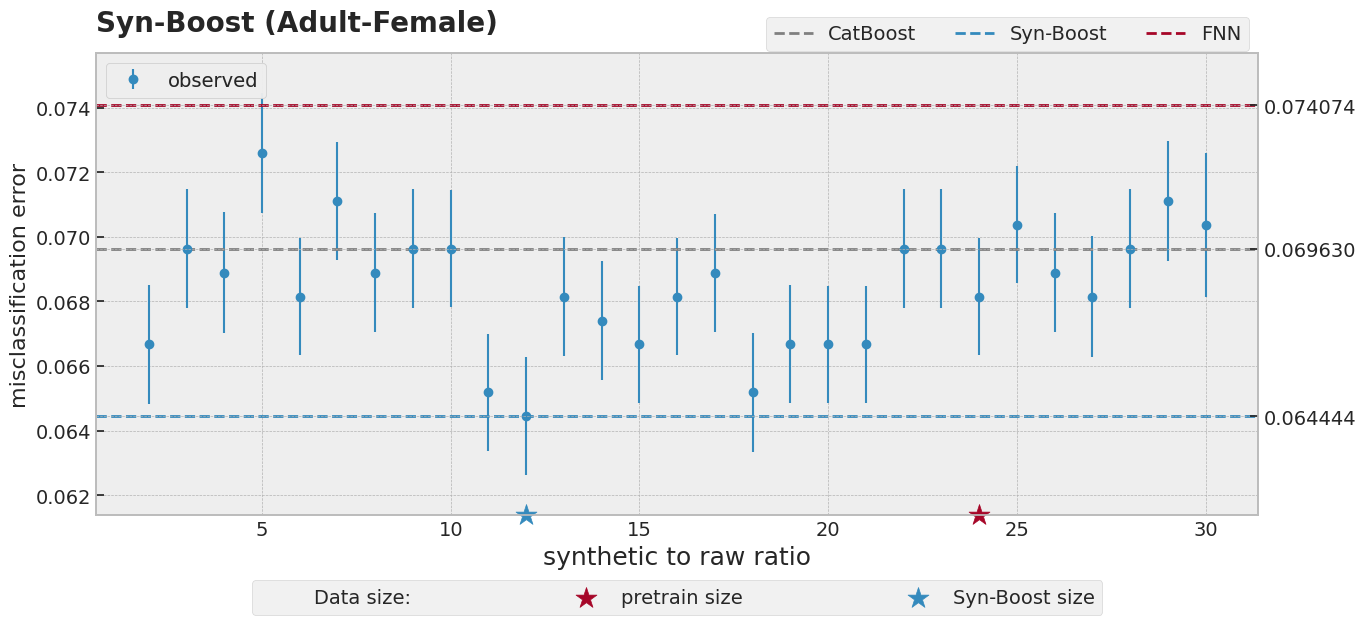

In [28]:
fake_to_real_ratio = result_female["rhos"]
best_score_list = 1 - np.array(result_female["scores"])
best_score_catboost = 1 - score_catboost
nn_best_score = 1 - score_fnn

syngen_size = fake_to_real_ratio[np.argmin(best_score_list)]  # tuned syngen size
myspline = MySpline(fake_to_real_ratio, best_score_list, n_interior_knots=5, k=2)


xnew = np.linspace(fake_to_real_ratio.min(), fake_to_real_ratio.max(), 300)
y_pred, y_pred_se = myspline.pred(xnew)

fig, ax = plt.subplots(figsize=(15, 6))


# 1. add scatter plot of observed data and fitted spline
# ## Option 1: smoothing spline and fitted values
# spline_obs = ax.scatter(
#     fake_to_real_ratio,
#     best_score_list,
#     marker="s",
#     label="observed",
#     # mew=2,
#     # linestyle="-",
#     # markersize=8,
#     # linewidth=2,
# )
# spline_fitted = ax.plot(xnew, y_pred, "-", label="fitted")
# se_scale = 1.96
# ax.fill_between(
#     xnew,
#     y_pred - se_scale * y_pred_se,
#     y_pred + se_scale * y_pred_se,
#     alpha=0.2,
#     color="C0",
# )


# initial_legend = plt.legend(
#     handles=[spline_obs, spline_fitted[0]],
#     loc="upper right",
#     fontsize=14,
#     bbox_to_anchor=[1, 0.8],
# )

## Option 2: error bar based on spline regression model
x, y = fake_to_real_ratio[1:], best_score_list[1:]
_, y_pred_se = myspline.pred(x)
sigma_hat = myspline.sigma_hat
y_se = np.sqrt(y_pred_se**2 + sigma_hat**2)

spline_fitted = ax.errorbar(
    x, y, yerr=y_se, fmt="o", elinewidth=1.5, label="observed"
)

initial_legend = plt.legend(
    handles=[spline_fitted],
    loc="upper left",
    fontsize=14,
    bbox_to_anchor=[0, 1],
)
plt.gca().add_artist(initial_legend)

y_min, y_max = ax.get_ylim()
y_min, y_max = min(y_min, nn_best_score, best_score_list.min()), max(
    y_max, nn_best_score, best_score_list.max()
)
y_min, y_max = y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)
ax.set_ylim(y_min, y_max)


# 2. add horizontal lines for baseline, FNN-reference and best syn-boost error curve
tuned_value = best_score_list.min()
error_catboost = ax.axhline(
    best_score_catboost, linestyle="--", color="grey", label="CatBoost"
)
error_synboost = ax.axhline(tuned_value, linestyle="--", color="C0", label="Syn-Boost")
error_fnn = ax.axhline(nn_best_score, linestyle="--", color="C1", label="FNN")

ax2 = ax.twinx()
ax2.set_yticks([best_score_catboost, tuned_value, nn_best_score])

ax.tick_params(axis="both", which="major", labelsize=14)
ax2.set_ylim(ax.get_ylim())
ax2.tick_params(axis="both", which="major", labelsize=14)

first_legend = plt.legend(
    handles=[error_catboost, error_synboost, error_fnn],
    loc="upper right",
    fontsize=14,
    ncol=3,
    bbox_to_anchor=[1, 1.1],
)
plt.gca().add_artist(first_legend)


# 3. add legends of sizes: pretrain size and tuned Syn-Boost size
size_marker_kargs = {
    "y": y_min,
    "marker": "*",
    "zorder": 10,
    "clip_on": False,
    "s": 250,
}
size_title = plt.plot([], marker="", ls="")[0]
size_pretrain = ax.scatter(
    x=24,
    color="C1",
    label="pretrain size",
    **size_marker_kargs,
)
size_synboost = ax.scatter(
    x=syngen_size, color="C0", label="Syn-Boost size", **size_marker_kargs
)
plt.legend(
    handles=[size_title, size_pretrain, size_synboost],
    loc="upper center",
    bbox_to_anchor=[0.5, -0.12],
    ncol=4,
    fontsize=14,
    columnspacing=8,
    labels=["Data size:", "pretrain size", "Syn-Boost size"],
)

ax.set_xlabel("synthetic to raw ratio", fontsize=18)
ax.set_ylabel("misclassification error", fontsize=16)
ax.set_title(
    "Syn-Boost (Adult-Female)",
    weight="bold",
    fontsize=20,
    loc="left",
    y=1.03,
)

In [ ]:
print(
    "Syn-Boost over CatBoost:",
    (best_score_catboost - tuned_value) / best_score_catboost * 100,
)
print("Syn-Boost over FNN:", (nn_best_score - tuned_value) / nn_best_score * 100)

Syn-Boost over CatBoost: 5.319148936170143
Syn-Boost over FNN: 10.999999999999972
